# 1.Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

# 2.Loading and inspecting the dataset

In [63]:
df = pd.read_csv("KaggleV2-May-2016.csv")
print(df.head())
print(df.info())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

From the information regarding the data, it is seen that, there are 110527 entries, and all of the columns have 110527 non-null elements. Which implies that there are no missing values in the dataset.

# 3.Data Cleaning

In [64]:
# Renaming columns
df.columns = [col.strip().lower().replace('-', '_') for col in df.columns]

# Convert 'scheduledday' and 'appointmentday' to datetime
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

# Create new features
df['waiting_days'] = (df['appointmentday'] - df['scheduledday']).dt.days
df['appointment_weekday'] = df['appointmentday'].dt.day_name()

# Convert 'no_show' to binary (1 = no-show, 0 = show)
df['no_show'] = df['no_show'].map({'Yes': 1, 'No': 0})

# Remove unrealistic values
df = df[df['age'] >= 0]

# 4.EDA - Analyzing Trends

Text(0.5, 1.0, 'No-Show Rate by Day of the Week')

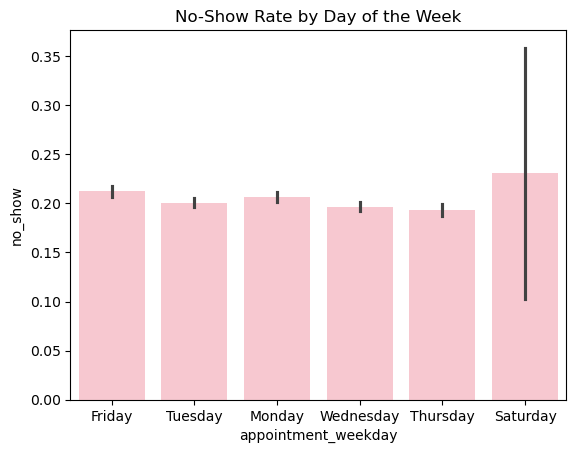

In [65]:
sns.barplot(data=df, x='appointment_weekday', y='no_show',color='pink')
plt.title('No-Show Rate by Day of the Week')

Text(0.5, 1.0, 'Age Distribution vs No-Show')

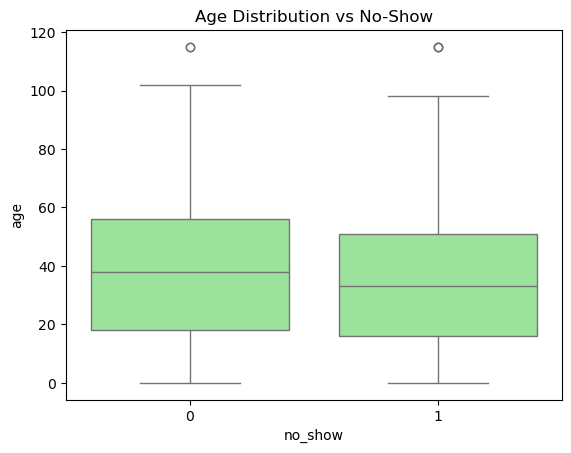

In [66]:
sns.boxplot(data=df, x='no_show', y='age',color='lightgreen')
plt.title('Age Distribution vs No-Show')

Text(0.5, 1.0, 'SMS Received vs No-Show Rate')

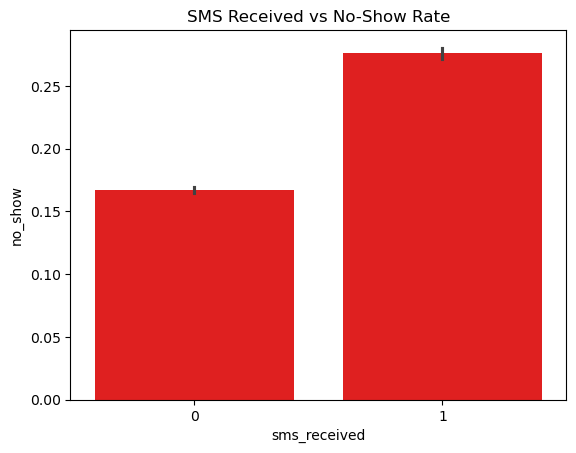

In [67]:
sns.barplot(data=df, x='sms_received', y='no_show',color='red')
plt.title('SMS Received vs No-Show Rate')

# 5.Prepare Data for Modeling

In [68]:
features = ['age', 'scholarship', 'hipertension', 'diabetes', 
            'alcoholism', 'handcap', 'sms_received', 'waiting_days']
X = df[features]
y = df['no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6.Train Decision Tree

In [69]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

# 7.Evaluate Model

In [70]:
y_pred = clf.predict(X_test)

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix: 
[[26539    21]
 [ 6577    21]]


26539 — correctly predicted class 0

21 — predicted class 1, but actual is 0

6577 — predicted class 0, but actual is 1

21 — correctly predicted class 1

In [71]:
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     26560
           1       0.50      0.00      0.01      6598

    accuracy                           0.80     33158
   macro avg       0.65      0.50      0.45     33158
weighted avg       0.74      0.80      0.71     33158



Classification Report:
Overall Accuracy: 80% (due to overwhelming number of class 0 predictions)

Macro Average: Averages each class equally — reveals poor performance on class 1

Weighted Average: Takes class imbalance into account — still shows weak performance on class 1

# Visualize the Tree

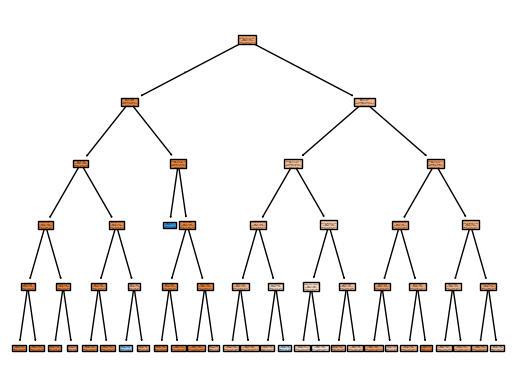

In [72]:
plot_tree(clf, feature_names=features, class_names=["Show", "No-Show"], filled=True)
plt.show()

CONCLUSION

Decision Tree model is predicting that everyone will show up (class 0), which is why it's doing well on accuracy (80%), but terribly on identifying actual no-shows (class 1).

The model is highly biased toward class 0, likely due to class imbalance (26560 vs. 6598 is roughly a 4:1 ratio).

While the accuracy is high, the recall for class 1 is 0, meaning the model fails to identify the minority class almost entirely.

The F1-score for class 1 is only 0.01, which is extremely poor.

So, trying other methods so as to increase the accuracy of predicting no-show cases.

# XGBoost Method

In [98]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve

In [100]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Apply SMOTE to balance the training set
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

#Train XGBoost classifier
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)

#Make predictions
y_pred = xgb.predict(X_test_scaled)
y_probs = xgb.predict_proba(X_test_scaled)[:, 1]  # probability of class 1

#Evaluation
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[14464 12096]
 [ 1347  5251]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.54      0.68     26560
           1       0.30      0.80      0.44      6598

    accuracy                           0.59     33158
   macro avg       0.61      0.67      0.56     33158
weighted avg       0.79      0.59      0.63     33158



XGBoost

Confusion Matrix:

Recall for No-Show increased significantly (80%).
However, the precision for No-Show dropped to 30%.

XGBoost is one of the best models in terms of recall for class 1, which is what we need to detect no-shows.
Precision is still low, meaning the model is over-predicting no-shows (false positives).

After doing the undersampling, SMOTE oversampling, Random Forest Method and XGBoost method, by far 80% is the highest accuracy. Hence this model with XGBoost method is the most suitable to predict whether patients will miss their appointments and optimize scheduling. 